In [261]:
#Installing new libraries, random commands

#!pip install wordcloud
#!pip install TextBlob
#!pip install xgboost
#!pip install lightgbm
#print(sys.executable)

In [262]:
#Packages Required

#Basic
import pandas as pd
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings("ignore")

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter

#Text Processing
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

#ML
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [263]:
#Importing Data
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.shape

(23486, 11)

In [264]:
#Understand data structure
df.info() # need to drop the index 0 column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [266]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [267]:
#Preprocessing of df
#drop the index column and clothing id as it is not needed
df.drop(df.columns[[0,1]],inplace=True, axis=1) # inplace=True returns None and not a copy of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


In [269]:
#Check for missing values
df.isnull().sum()
#Review Text has the maximum number of missing values, followed by Div Name, Dept Name and Class Name equally

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [270]:
#Now, to understand the general trend of length of reviews, a length column will help with that
df['Review Length'] = df['Review Text'].astype(str).apply(len)

In [271]:
#I have considered a rating of 3 and above as positive ie 1 and 
# a rating of 2 and below as negative ie 0
df['Perception of Product'] = np.where(df['Rating'] >= 3, 1, 0)

In [272]:
#Remove missing values particularly from division name, class name, dept name as it wont aid in analysis.
#The review text column needs to be complete, hence missing values in those are dropped as well
#Title wont be for ML modeling, hence the column will be dropped altogether before ML modeling
for column in ["Class Name","Department Name","Division Name","Review Text"]:
    df = df[df[column].notnull()]
df.isnull().sum() #no more missing values in important columns for analysis

Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                 0
Department Name               0
Class Name                    0
Review Length                 0
Perception of Product         0
dtype: int64

In [274]:
#Check for unique values
df.nunique()

Age                           77
Title                      13983
Review Text                22621
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
Review Length                497
Perception of Product          2
dtype: int64

**EDA**


In [275]:
df.describe() #describing new df

,Age,Rating,Recommended IND,Positive Feedback Count,Review Length,Perception of Product
count,22628.000000,22628.000000,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,0.818764,2.631784,308.761534,0.895263
std,12.328176,1.115911,0.385222,5.787520,143.934126,0.306222
min,18.000000,1.000000,0.000000,0.000000,9.000000,0.000000
25%,34.000000,4.000000,1.000000,0.000000,186.000000,1.000000
50%,41.000000,5.000000,1.000000,1.000000,302.000000,1.000000
75%,52.000000,5.000000,1.000000,3.000000,459.000000,1.000000
max,99.000000,5.000000,1.000000,122.000000,508.000000,1.000000


**Exploratory Data Analysis**


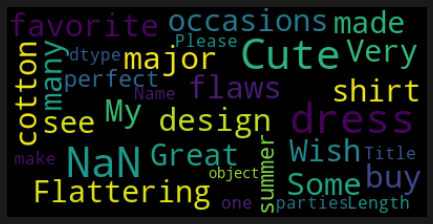

In [276]:
#Word Cloud for Title

import matplotlib as mpl
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100              
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=12
                         ).generate(str(df['Title']))

fig = plt.figure(dpi=70, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

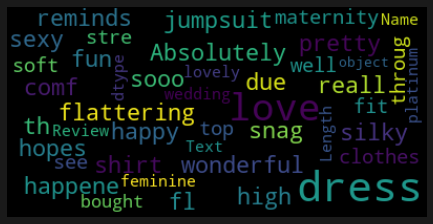

In [277]:
#Word Cloud for Review Text

import matplotlib as mpl
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100          
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=12
                         ).generate(str(df['Review Text']))

fig = plt.figure(dpi=70, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

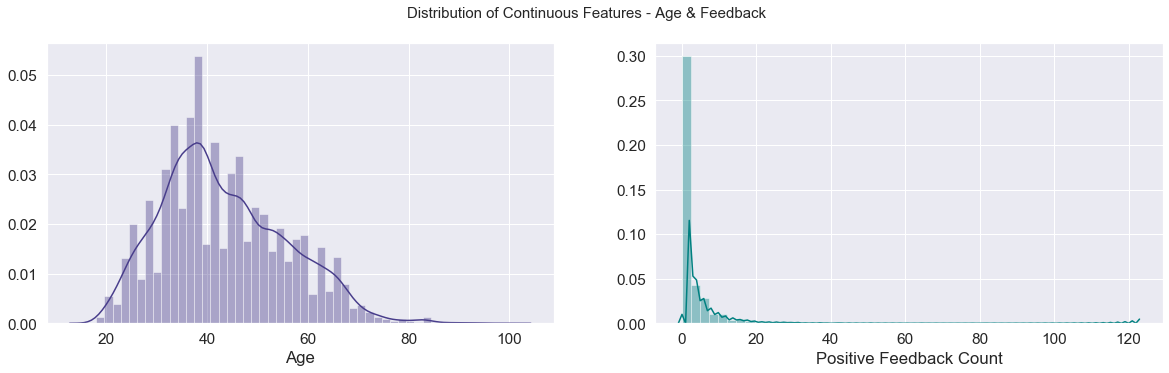

In [278]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df["Age"], color="darkslateblue", ax=ax[0])
sns.distplot(df["Positive Feedback Count"], color = 'teal', ax=ax[1])
fig.suptitle('Distribution of Continuous Features - Age & Feedback', fontsize=15);

From the distribution of Categorical Variables, it can be seen the the data set is unbalanced as "Recommended IND" has more people recommedning products than people who dont recommend products on the website.

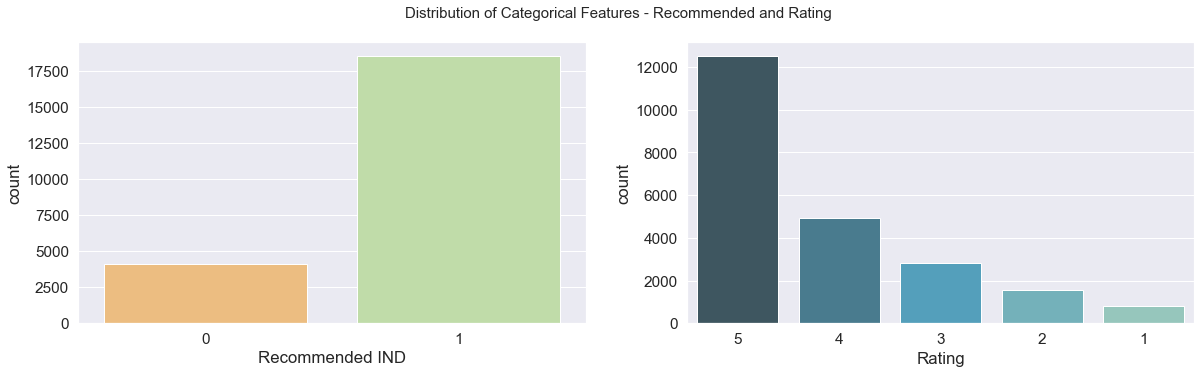

In [279]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.catplot(x="Recommended IND", kind = "count", palette=("Spectral"), data = df, ax=ax[0])
sns.catplot(x="Rating", kind = "count", palette=("GnBu_d"), data = df, order = df.Rating.value_counts().index, ax=ax[1])
fig.suptitle('Distribution of Categorical Features - Recommended and Rating', fontsize=15);
for i in range(2,4): 
    plt.close(i)

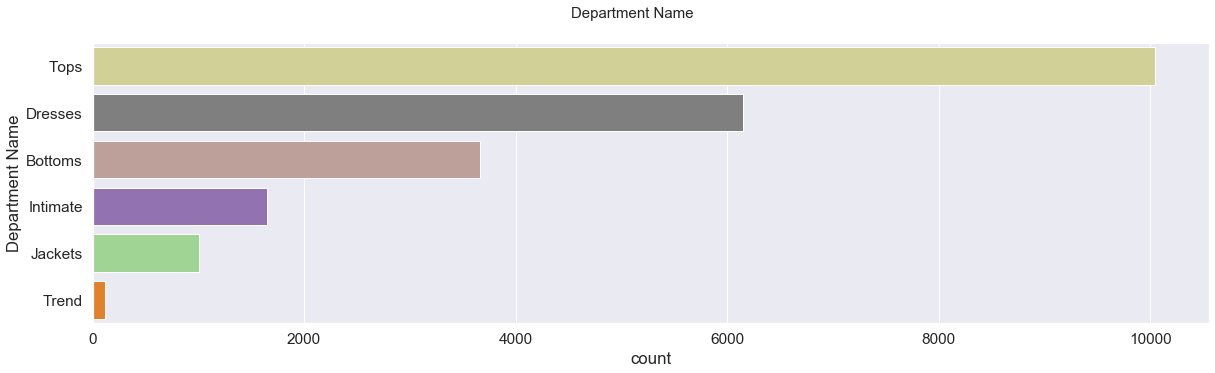

In [280]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(y="Department Name", palette = "tab20_r",data=df, order=df["Department Name"].value_counts().index)
fig.suptitle('Department Name', fontsize=15);

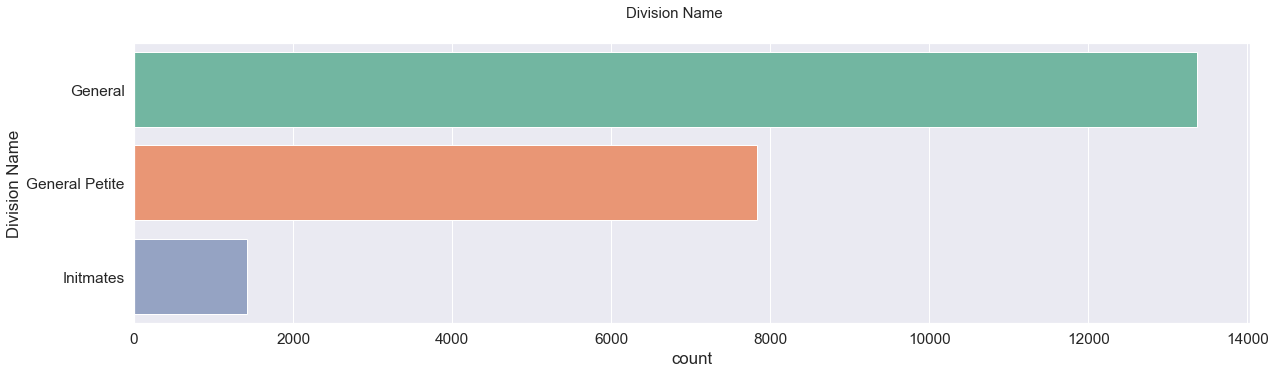

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(y="Division Name", palette = "Set2",data=df, order=df["Division Name"].value_counts().index)
fig.suptitle('Division Name', fontsize=15);

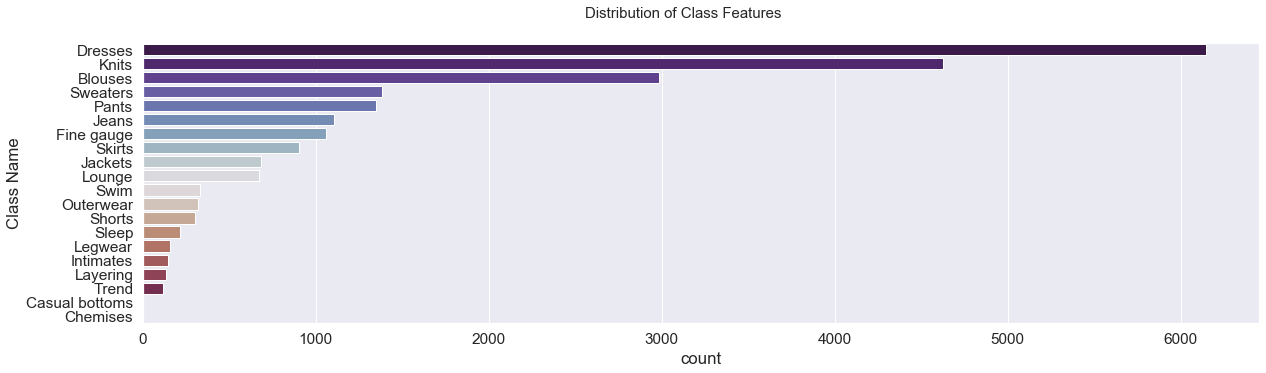

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(y="Class Name", palette = "twilight_shifted", data=df, order=df["Class Name"].value_counts().index)
fig.suptitle('Distribution of Class Features', fontsize=15);

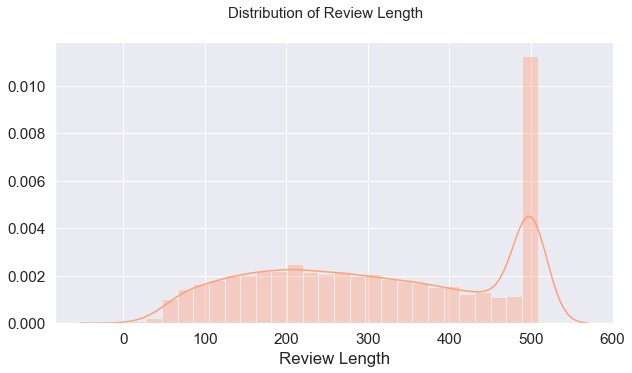

In [284]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.distplot(df['Review Length'], color = "lightsalmon")
fig.suptitle('Distribution of Review Length', fontsize=15);

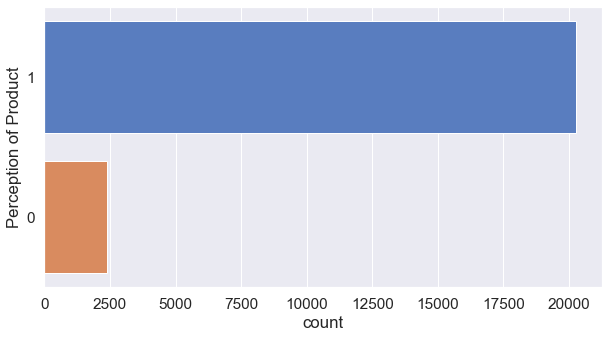

In [285]:
plt.figure(figsize=(10,5))
sns.countplot(y =df['Perception of Product'], palette = "muted", data = df, order=df["Perception of Product"].value_counts().index);

From the chart below, it can be seen that the users who gave a rating of 5, often wrote 500 plus word length reviews

<Figure size 1440x360 with 0 Axes>

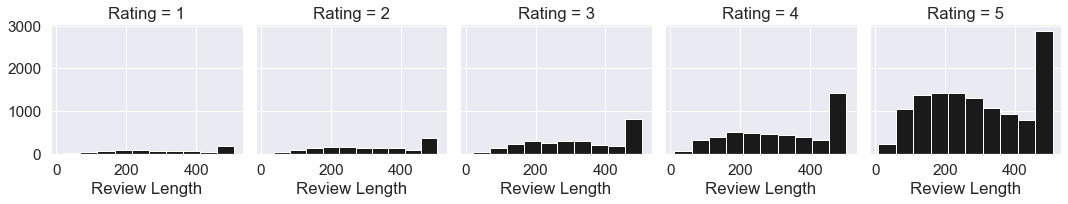

In [287]:
plt.figure(figsize=(20,5))
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Review Length', color = "k", bins=10);

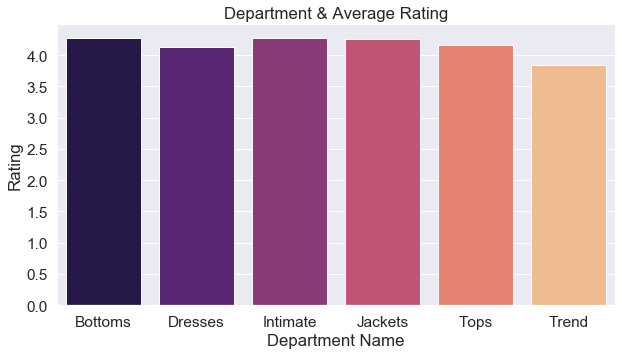

In [288]:
#Finding the average ratings of the departments

reco = df.groupby('Department Name', as_index=False).mean()[['Department Name','Rating']]
plt.figure(figsize=(10,5))
plt.title("Department & Average Rating")
chart = sns.barplot(x='Department Name', y='Rating',data = reco,palette = "magma")

**Identifying the Tone of the Reviews**

**Sentiment Polarity**


A product represents the tone of the review or the sentiment as negative, positive and neutral tone.

TextBlob uses a sentiment lexicon (consisting of predefined words) to assign scores for each word, which are then averaged out using a weighted average to give an overall sentence sentiment score. Three scores: “polarity”, “subjectivity” and “intensity” are calculated for each word.

Each word in the lexicon has scores for:

    1. polarity: negative vs. positive    (-1 to +1)
    2. subjectivity: objective vs. subjective (0 to +1)
    3. intensity: modifies next word?      (0.5 to 2)
    
   Eg : 
   TextBlob("great").sentiment
   (polarity=0.8, subjectivity=0.75)
   
   TextBlob("not great").sentiment 
   Sentiment(polarity=-0.4, subjectivity=0.75)
   
Recognizing “very” as a modifier word, TextBlob will ignore polarity and subjectivity and just use intensity to modify the following word: 

TextBlob("very great").sentiment 
(polarity=1.0, subjectivity=0.9750000000000001)

The subjectivity is  modified by “very” to become higher.

Very few predictions are strongly negative or positive — this makes sense because TextBlob uses a weighted average sentiment score over all the words in each sample.In our data, a large number of texts belong to the neutral polarity. Hence it is clear that our TextBlob classifier predicts most samples as neutral



In [289]:
# Defining a sentiment analyser function for polarity
def sentiment_analyser(review):
    return review.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

In [290]:
# Applying function to reviews
df['Polarity'] = sentiment_analyser(df['Review Text'])
df.sample(5)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Perception of Product,Polarity
21644,34,NaN,"I loved how soft this dress was, as well as ve...",1,0,1,General,Dresses,Dresses,500,0,0.054808
9769,46,NaN,Love this sweater. i have it in both colors. i...,4,1,2,General,Tops,Fine gauge,223,1,0.110697
21060,39,So cute!,Most casual tops are so sloppy now - not this ...,5,1,0,General Petite,Tops,Knits,97,1,0.155833
12416,53,Gorgeous white blouse,I love a good white blouse and this shirt does...,5,1,1,General,Tops,Blouses,321,1,0.205714
7447,41,Comfy sweatshirt,I have been living in mine since i bought it! ...,5,1,1,General,Tops,Knits,92,1,-0.267857


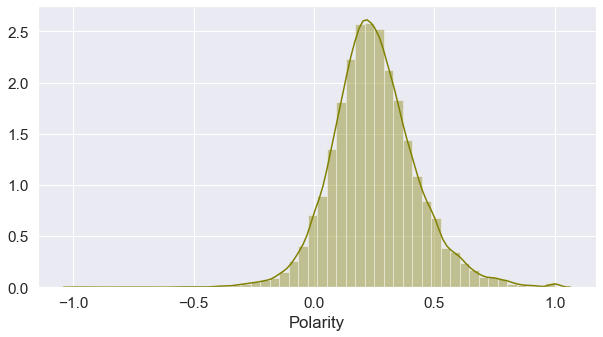

In [291]:
#Plotting Polarity
plt.figure(figsize=(10,5))
sns.distplot(df['Polarity'], color = 'olive');

To understanding how different polarities work across review texts, lets sample a few

In [292]:
pol = df.loc[df.Polarity == 1,['Review Text']].sample(5).values #Positive
print(pol)

[["I've been looking for an off the should sweater like this for over a year! looks great on and doesn't itch! can't wait for fall so i can wear it!"]
 ['I ordered the orange color too. these are perfect for throwing on over workout clothes and then running errands.']
 ['Made my wedding outfit perfect!']
 ['Bought this dress for an indian wedding- it was perfect!']
 ['This cover-up is perfect for the beach or the pool. it is see through.']]


In [122]:
pol = df.loc[df.Polarity == 0.5,['Review Text']].sample(5).values #Neutral
print(pol)

[['Love this top. fits me perfect. i am bigger on top and received many compliments in this shirt.']
 ['Such a beautiful, flattering dress! i bought this to wear for our anniversary dinner and received so many compliments.']
 ['I am wearing a medium in the photos and for reference my measurements are 38-30-40. i did not purchase this top.']
 ['The pattern of this skirt is adorable and looks better in person but the fabric isnt the best. it feels like an elastic fabric and is way to volumous. overall not my favorite.']
 ['I am 5\'3", 28/38 and got the sp. had no issues whatsoever, and love the colors.']]


In [121]:
pol =  df.loc[df.Polarity <0,['Review Text']].sample(5).values #Neutral
print(pol)

[["This dress has so much potential- loved the pattern and the neckline. however, only one side of the waist was gathered with a fake sash leaving the other side plain. the gathered side was super flattering while the other side showed any little lump or bump. needless to say, i'm returning it."]
 ["I purchased this in black. as in the other reviews the lace detail is a little snug in the arms but it did stretch. i did not have a problem with any fraying or quality issues. the shape is very flattering. i've been asked where i bought this several times."]
 ["I don't typically write bad reviews, but this dress is so bad and i want to save someone else from buying it. i read the mostly bad reviews and still purchased anyway (my fault i know). the dress is super stiff ( i know denim can be that way and it is possible it would soften up after a few washes). i'm typically a 6/8 and the size small swallowed me, and the xs was big everywhere except through the bust (i ordered both sizes to try

In [297]:
#Plotting Polarity

neg = sum(1 for i in df.Polarity if i<0) 
pos = sum(1 for i in df.Polarity if i>0.5) 
neu = sum(1 for i in df.Polarity if i>0) 

data = {'Negative':[neg], 'Neutal':[neu], 'Positive':[pos]}

poldf = pd.DataFrame(data) 
print(poldf)

   Negative  Neutal  Positive
0      1322   21214      1669


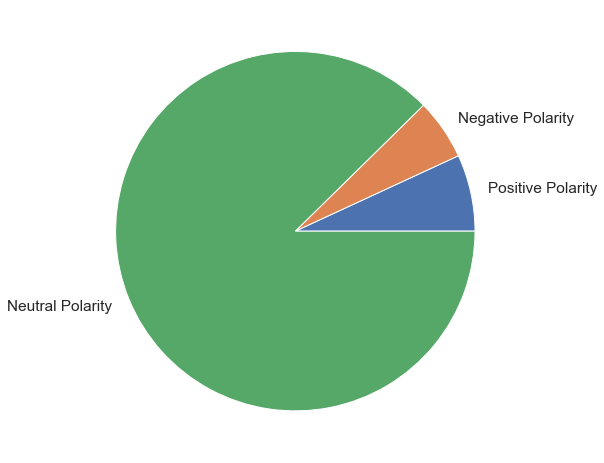

In [298]:
plt.figure(figsize =(10, 8)) 
plt.pie([pos,neg,neu], labels = ['Positive Polarity','Negative Polarity','Neutral Polarity']);

In [136]:
#Place holder for  Length vs Polarity Chart 


**Pre Processing of Text Data**



Using CountVectorizer


A major hiccup is that we cannot work with text directly when using machine learning algorithms. Therefore, its important to convert the text to numbers. Algorithms take vectors of numbers as input, hence we need to convert documents to fixed-length vectors of numbers.

The scikit-learn library offers easy-to-use tools to perform both tokenization and feature extraction of text data.

Therefore, CountVectorizer provides us with the number of times a word appears a text. It provides a way to tokenize and print a vocabulary of words. This can be done by assigning each word a unique number. Any text column can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document. An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. The following are the steps involved in Vectorizing :

1. Create an instance of the CountVectorizer class.
2. Call the fit() function in order to learn a vocabulary from one or more documents.
3. Call the transform() function on one or more documents as needed to encode each as a vector.
4. Above two steps can be merged to one step

The vector returned from a call to transform() will have a lot of zeroes known as sparse vectors, and its important to transform it to numpy array so that we understand it better by calling the toarray() function.

 By default, CountVectorizer does the following:

- lowercases your text (set lowercase=false if you don’t want lowercasing)
- uses utf-8 encoding
- performs tokenization (converts raw text to smaller units of text)
- uses word level tokenization (meaning each word is treated as a separate token)
- ignores single characters during tokenization (say goodbye to words like ‘a’ and ‘I’)

Here, stop words are critical because if we remove the words that are very commonly used in a given language, we can focus on the important words instead and imporves the predictive power. CountVectorizer also provides in built English stop word list or we can create a corpus. I have used the inbuilt list.


https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://kavita-ganesan.com/how-to-use-countvectorizer/#Example-of-How-CountVectorizer-Works

https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4

In [299]:
#Vectorizing Data


#create transform fn with CountVectorizer() class
vectorizer = CountVectorizer()

#Return a callable that handles preprocessing, tokenization and n-grams generation.
#build_analyzer() returns a callable that let's you extract the tokenizing step from the transformation pipeline wrapped in the CountVectorizer
#applies preprocessing, tokenization, remove stop words and creates n-grams.
analyze = vectorizer.build_analyzer()

def count_of_words(x):
    a = {}
    if analyze(x):
        b = {}
        
        #This is equivalent to fit followed by transform, but more efficiently implemented.
        c = vectorizer.fit_transform([x]).toarray()
        # vocabulary and index
        d = vectorizer.vocabulary_
        for y,z in d.items():
            b[z]=y # index:word 
        for index,i in enumerate(c[0]):
            a[b[index]] = i # word:count
    return  a

df['Count of Words'] = df['Review Text'].apply(count_of_words)
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Perception of Product,Polarity,Count of Words
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,1,0.633333,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,1,0.339583,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500,1,0.073675,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."


**Feature Extraction : Machine learning Models**


**Spliting Data**

In [300]:
X = vectorizer.fit_transform(df['Review Text'])

In [321]:
y = df['Perception of Product']

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
print('Train/Test Size : ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Train/Test Size :  (16971, 14144) (5657, 14144) (16971,) (5657,)


**Models**

**Logistic Regression**

In [307]:
#Fitting Logistic Regression Model
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train);

The accuracy score is 89.0
[[ 625  367]
 [ 255 4410]]


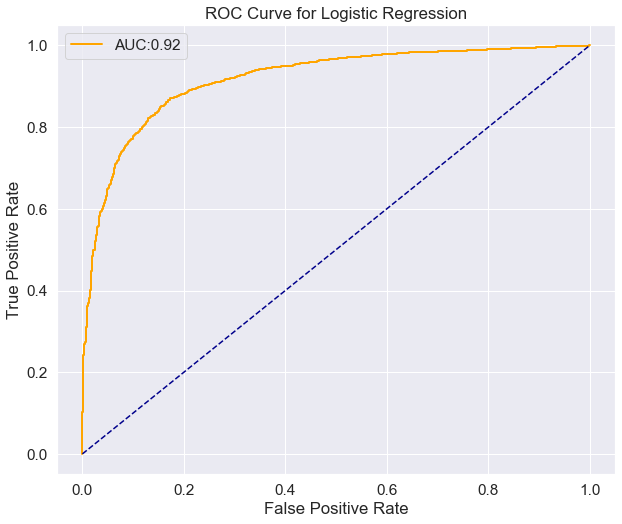

Classification Report for Logistic Regression:  
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       992
           1       0.92      0.95      0.93      4665

    accuracy                           0.89      5657
   macro avg       0.82      0.79      0.80      5657
weighted avg       0.89      0.89      0.89      5657



In [308]:
#Accuracy Score
lr_score = accuracy_score(y_test,lr.predict(X_test))
print('The accuracy score is ' + str(round(lr_score,3)*100))

#Confusion Matrix
lr_matrix=confusion_matrix(y_test.values,lr.predict(X_test))
print(lr_matrix)

#ROC Curve
predict_lr = lr.predict_proba(X_test)[:,1]
fp_lr,tp_lr,th = roc_curve(y_test,predict_lr)
auc_lr = auc(fp_lr,tp_lr)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_lr), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Logistic Regression')
    plt.legend()
    plt.show()
plot_roc_curve(fp_lr, tp_lr)

#Classification Report
print("Classification Report for Logistic Regression:  \n",classification_report(y_test,lr.predict(X_test)))

**Naive Bayes**

The general term Naive Bayes refers the the strong independence assumptions in the model, rather than the particular distribution of each feature.

Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features.

BernoulliNB works for binary features such as 1,0 or  features that take only two values. In this case 0 means “negative rating or a negative perception of the product" occur in the document” and 1s as "word occurs in the document" 

In [309]:
#Fitting Naive Bayes Model

nb = BernoulliNB()
nb.fit(X_train,y_train);

The accuracy score is 87.6
[[ 646  346]
 [ 354 4311]]


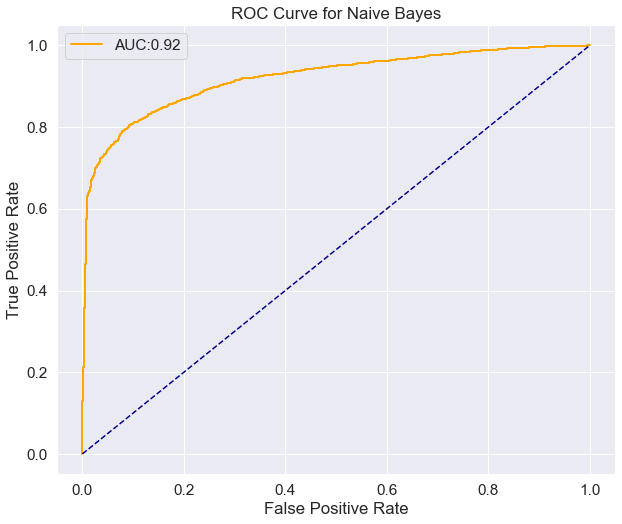

Classification Report for Naive Bayes:  
               precision    recall  f1-score   support

           0       0.65      0.65      0.65       992
           1       0.93      0.92      0.92      4665

    accuracy                           0.88      5657
   macro avg       0.79      0.79      0.79      5657
weighted avg       0.88      0.88      0.88      5657



In [310]:
#Accuracy Score
nb_score = accuracy_score(y_test,nb.predict(X_test))
print('The accuracy score is ' + str(round(nb_score,3)*100))

#Confusion Matrix
nb_matrix=confusion_matrix(y_test.values,nb.predict(X_test))
print(nb_matrix)

#ROC Curve
predict_nb = nb.predict_proba(X_test)[:,1]
fp_nb,tp_nb,th = roc_curve(y_test,predict_nb)
auc_nb = auc(fp_nb,tp_nb)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_nb), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_nb, tp_nb)

#Classification Report
print("Classification Report for Naive Bayes:  \n",classification_report(y_test,nb.predict(X_test)))

**SVM**

LinearSVC in comparision to SVC is more flexible and scalable implementation of SVC with linear kernel. The Linear SVC algorithm is much more efficient and can scale accordingly for large data sets otherwise SVC makes it hard to scale to dataset with more than a couple of 10000 samples and is inconsistent

In [311]:
#Fitting Support Vector Machine Model
#from sklearn.svm import LinearSVC
sv = LinearSVC()
sv.fit(X_train, y_train);

The accuracy score is 87.0
[[ 603  389]
 [ 348 4317]]


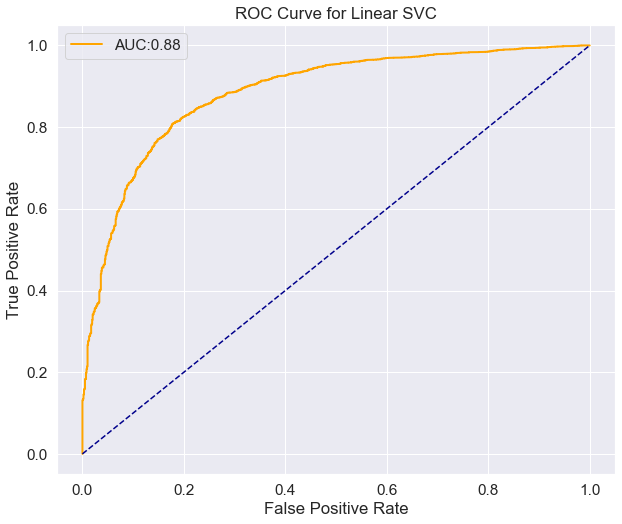

Classification Report for Support Vector Machine:  
               precision    recall  f1-score   support

           0       0.63      0.61      0.62       992
           1       0.92      0.93      0.92      4665

    accuracy                           0.87      5657
   macro avg       0.78      0.77      0.77      5657
weighted avg       0.87      0.87      0.87      5657



In [312]:
#Accuracy Score
sv_score = accuracy_score(y_test,sv.predict(X_test))
print('The accuracy score is ' + str(round(sv_score,3)*100))

#Confusion Matrix
sv_matrix=confusion_matrix(y_test.values,sv.predict(X_test))
print(sv_matrix)

#ROC Curve
predict_sv = sv.decision_function(X_test)
fp_sv,tp_sv,th = roc_curve(y_test,predict_sv)
auc_sv = auc(fp_sv,tp_sv)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_sv), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Linear SVC')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_sv, tp_sv)

#Classification Report
print("Classification Report for Support Vector Machine:  \n",classification_report(y_test,sv.predict(X_test)))

**Random Forest**

In [313]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

In [314]:
#Accuracy Score
rf_score = accuracy_score(y_test,rf.predict(X_test))
print('The accuracy score is ' + str(round(rf_score,3)*100))

The accuracy score is 85.0


[[ 324  668]
 [ 179 4486]]


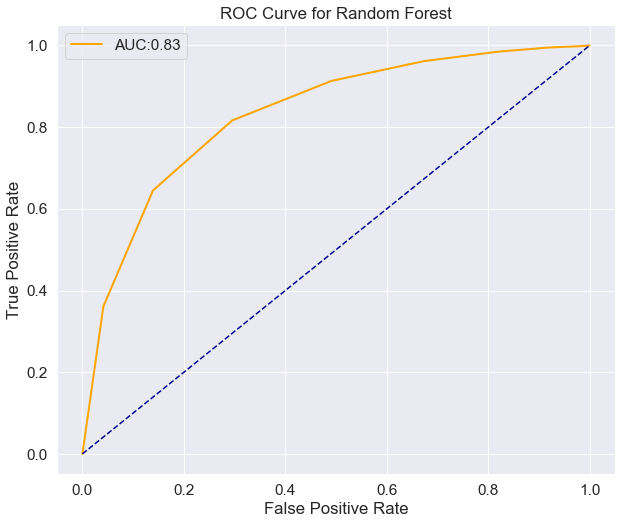

Classification Report for Randon Forest:  
               precision    recall  f1-score   support

           0       0.64      0.33      0.43       992
           1       0.87      0.96      0.91      4665

    accuracy                           0.85      5657
   macro avg       0.76      0.64      0.67      5657
weighted avg       0.83      0.85      0.83      5657



In [315]:
#Confusion Matrix
rf_matrix=confusion_matrix(y_test.values,rf.predict(X_test))
print(rf_matrix)

#ROC Curve
predict_rf = rf.predict_proba(X_test)[:,1]
fp_rf,tp_rf,th = roc_curve(y_test,predict_rf)
auc_rf = auc(fp_rf,tp_rf)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_rf), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Random Forest')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_rf, tp_rf)

#Classification Report
print("Classification Report for Randon Forest:  \n",classification_report(y_test,rf.predict(X_test)))

**XG Boosting**

In [316]:
xg = XGBClassifier()
xg.fit(X_train, y_train);

In [317]:
#Accuracy Score
xg_score = accuracy_score(y_test,xg.predict(X_test))
print('The accuracy score is ' + str(round(xg_score,3)*100))

The accuracy score is 87.9


[[ 517  475]
 [ 212 4453]]


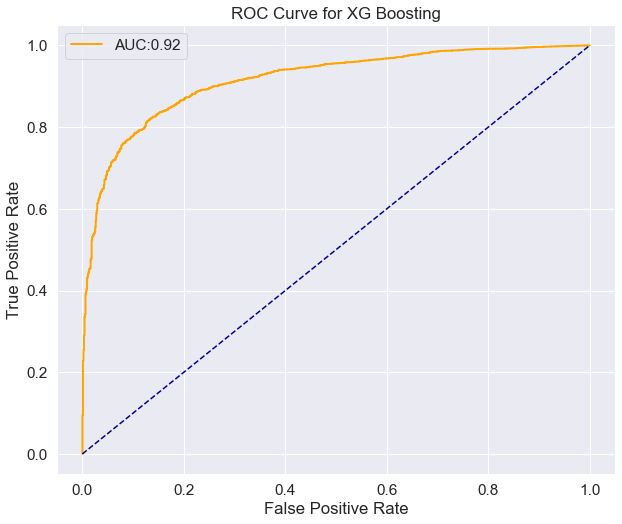

Classification Report:  
               precision    recall  f1-score   support

           0       0.71      0.52      0.60       992
           1       0.90      0.95      0.93      4665

    accuracy                           0.88      5657
   macro avg       0.81      0.74      0.76      5657
weighted avg       0.87      0.88      0.87      5657



In [318]:
#Confusion Matrix
xg_matrix=confusion_matrix(y_test.values,xg.predict(X_test))
print(xg_matrix)

#ROC Curve
predict_xg = xg.predict_proba(X_test)[:,1]
fp_xg,tp_xg,th = roc_curve(y_test,predict_xg)
auc_xg = auc(fp_xg,tp_xg)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_xg), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XG Boosting')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_xg, tp_xg)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,xg.predict(X_test)))

**Lasso Regression**

In [319]:
ls= LogisticRegressionCV(penalty = 'l1', solver ='liblinear', cv=5)
ls.fit(X_train,y_train);

The accuracy score is 89.0
[[ 584  408]
 [ 216 4449]]


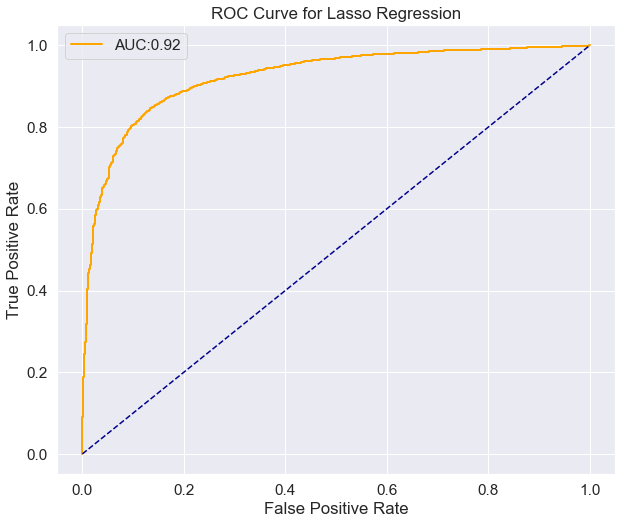

Classification Report for Lasso Regression:  
               precision    recall  f1-score   support

           0       0.73      0.59      0.65       992
           1       0.92      0.95      0.93      4665

    accuracy                           0.89      5657
   macro avg       0.82      0.77      0.79      5657
weighted avg       0.88      0.89      0.88      5657



In [320]:
#Accuracy Score
ls_score = accuracy_score(y_test,ls.predict(X_test))
print('The accuracy score is ' + str(round(ls_score,3)*100))

#Confusion Matrix
ls_matrix=confusion_matrix(y_test.values,ls.predict(X_test))
print(ls_matrix)

#ROC Curve
predict_ls = ls.predict_proba(X_test)[:,1]
fp_ls,tp_ls,th = roc_curve(y_test,predict_ls)
auc_ls = auc(fp_ls,tp_ls)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_ls), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Lasso Regression')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_ls, tp_ls)

#Classification Report
print("Classification Report for Lasso Regression:  \n",classification_report(y_test,ls.predict(X_test)))


In [228]:
#Rough Here on wards
import itertools

In [254]:
def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

In [255]:
common_words = top_n_ngram(df['Count of Words'], 20,1)
df = pd.DataFrame(common_words, columns = ['Count of Words', 'count'])
plt.figure(figsize =(10,5))
df.groupby('Count of Words').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 unigrams in review after removing stop words')

KeyError: 'Count of Words'